# **Dataset dan Konfigurasi Sistem**

Unduh dan buat folder untuk menampung dataset dengan API Kaggle

In [ ]:
%%bash

mkdir -p ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download --unzip -d jorghiinzaghitanson/posisi-duduk-ergonomis -p data

Dataset URL: https://www.kaggle.com/datasets/jorghiinzaghitanson/posisi-duduk-ergonomis
License(s): unknown



100%|██████████| 3.94G/3.94G [00:49<00:00, 85.0MB/s]


Instal pustaka splitfolder

In [ ]:
!pip install split-folders -qq

Impor pustaka untuk kebutuhan visualisasi data dan pembangunan model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import splitfolders
import matplotlib.pyplot as plt

Atur random seed untuk memastikan reproduktivitas hasil

In [ ]:
tf.random.set_seed(42)

Deklarasi variabel global untuk ukuran citra

In [ ]:
IMAGE_SIZE = (224, 224)

# **Perancangan Data**

Bagi dataset dengan rasio 80:10:10

In [ ]:
splitfolders.ratio('data/sitting-posture-dataset', ratio=(0.8, 0.1, 0.1))

Copying files: 1620 files [00:59, 27.33 files/s]


Muat dataset dengan parameter yang telah ditentukan

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'output/train',
    label_mode='binary',
    batch_size=32,
    image_size=IMAGE_SIZE,
    interpolation='bilinear',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'output/val',
    label_mode='binary',
    batch_size=32,
    image_size=IMAGE_SIZE,
    interpolation='bilinear',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    'output/test',
    label_mode='binary',
    batch_size=32,
    image_size=IMAGE_SIZE,
    interpolation='bilinear',
    shuffle=False,
)

Found 1296 files belonging to 2 classes.
Found 162 files belonging to 2 classes.
Found 162 files belonging to 2 classes.


Ambil batch pertama dari data train untuk kebutuhan demonstrasi

In [ ]:
images, labels = next(iter(train_ds.take(1)))

Tampilkan 5 sampel data train pertama dari batch pertama

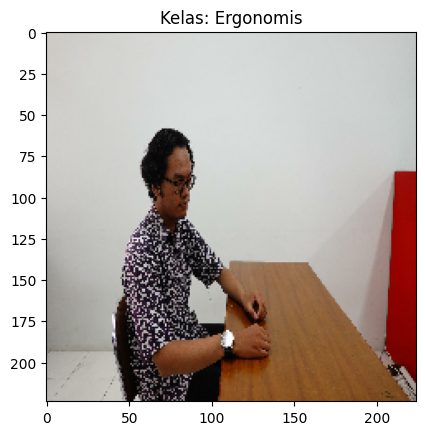

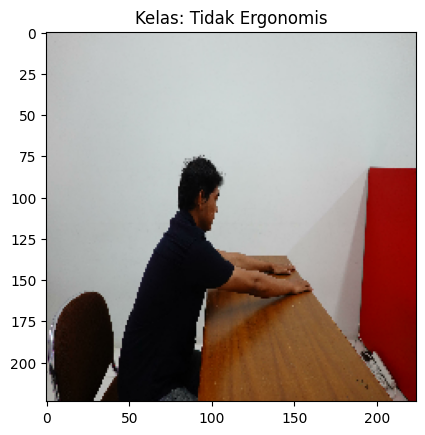

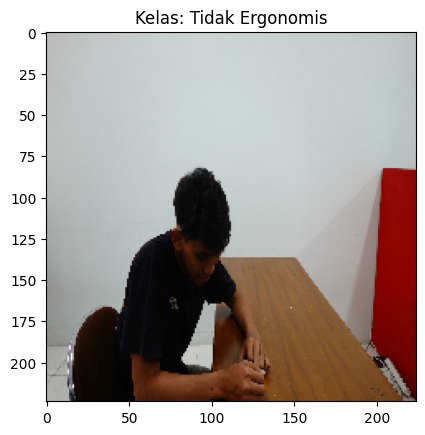

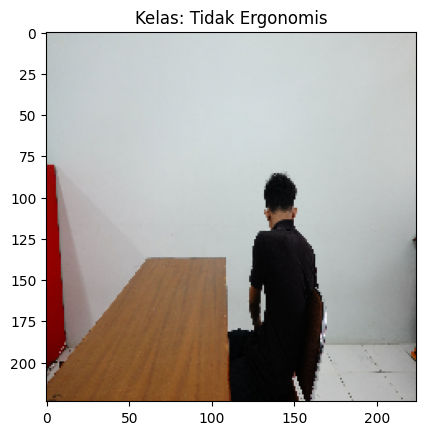

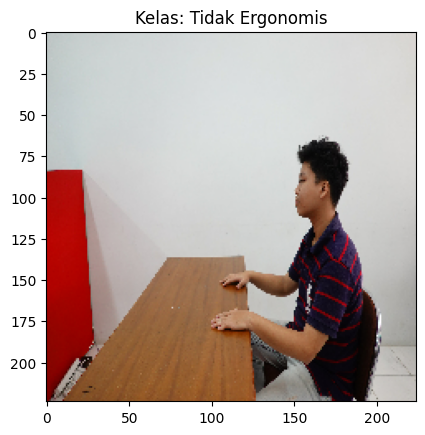

In [ ]:
for i in range(min(5, images.shape[0])):
  plt.imshow(images[i].numpy().astype("uint8"))
  label_text = "Ergonomis" if labels[i].numpy() == 0 else "Tidak Ergonomis"
  plt.title(f"Kelas: {label_text}")
  plt.show()

Optimasi dataset dengan autotune untuk mempercepat pelatihan data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Pembuatan Model**

Deklarasi Augmentasi Data

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom((-0.2, 0.0)),
    layers.RandomBrightness((-0.2, 0.0)),
], name='augmentation')

Deklarasi model dengan arsitektur MobileNetV2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(*IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet',
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Susun layer untuk model dan bekukan bobot agar tidak diperbarui saat pelatihan model

In [ ]:
base_model.trainable = False

inputs = tf.keras.Input(shape=(*IMAGE_SIZE,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

Instal graphviz dan pydot untuk visualisasi model

In [ ]:
!pip install pydot graphviz

Tampilkan layer model

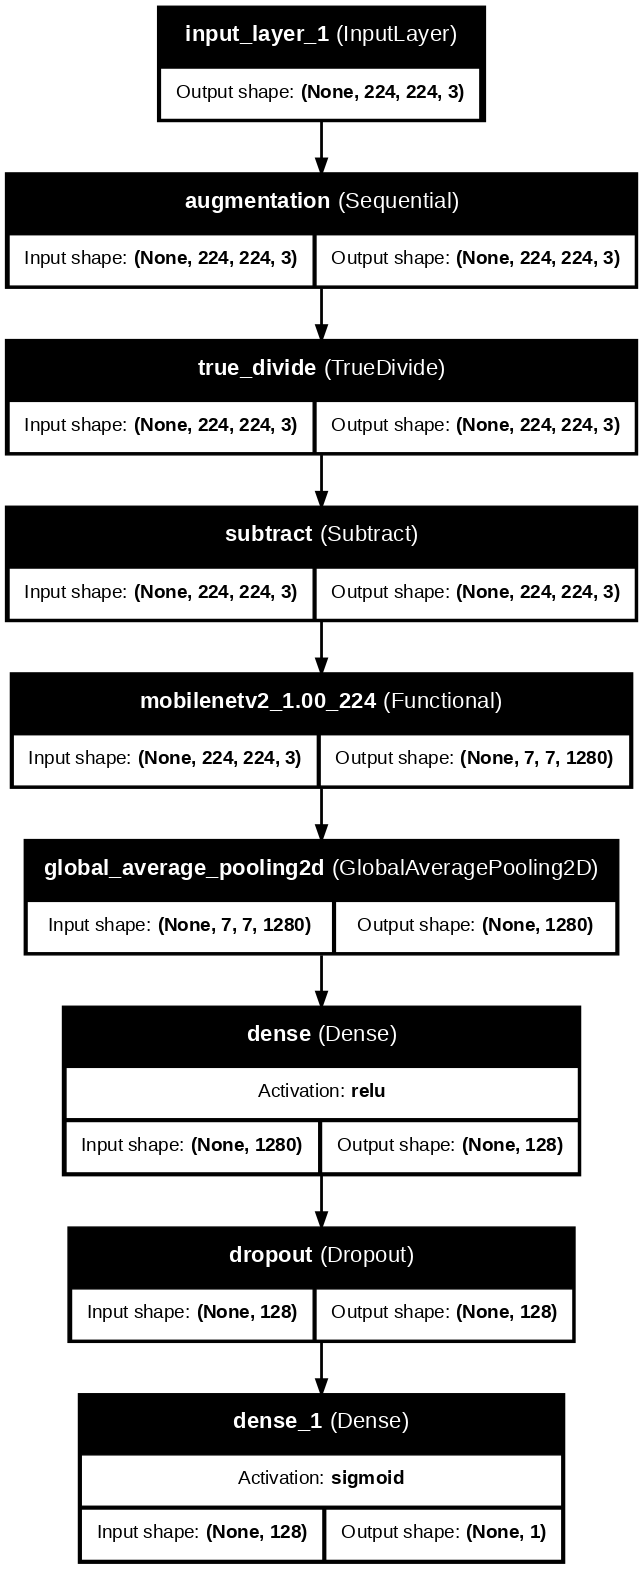

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

Tampilkan hasil augmentasi data dari sampel pertama

Original Image shape	:  (224, 224, 3)
Augmented Image shape	:  (224, 224, 3)


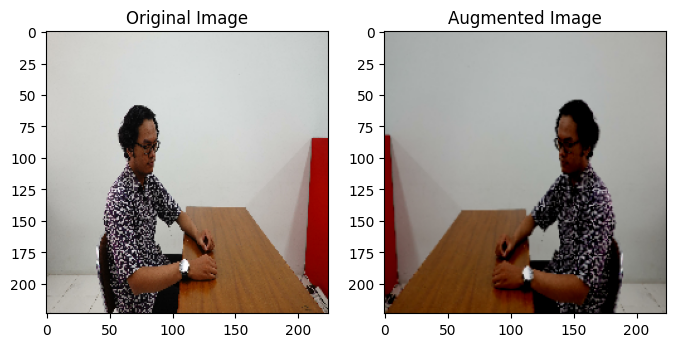

In [ ]:
print("Original Image shape\t: ", images[0].shape)
print("Augmented Image shape\t: ", data_augmentation(tf.expand_dims(images[0], axis=0))[0].shape)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(images[0].numpy().astype("uint8"))
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(data_augmentation(tf.expand_dims(images[0], axis=0)).numpy()[0].astype("uint8"))
plt.title("Augmented Image")
plt.show()

Tampilkan nilai piksel sampel pertama dari batch pertama sebelum dan setelah dilakukan penskalaan dan pemusatan data

In [ ]:
print("Nilai piksel sebelum penskalaan dan pemusatan data:")
print(images[0].numpy().astype("uint8"))

print("\nNilai piksel setelah penskalaan dan pemusatan data:")
print(preprocess_input(tf.expand_dims(images[0], axis=0)).numpy()[0])

Nilai piksel sebelum penskalaan dan pemusatan data:
[[[206 203 198]
  [205 202 197]
  [206 203 198]
  ...
  [195 200 194]
  [193 197 196]
  [195 195 195]]

 [[206 203 198]
  [206 203 198]
  [206 203 198]
  ...
  [192 196 195]
  [192 196 195]
  [191 195 194]]

 [[206 203 198]
  [205 202 197]
  [207 204 199]
  ...
  [191 195 194]
  [193 197 196]
  [191 197 195]]

 ...

 [[185 180 174]
  [188 185 178]
  [183 178 172]
  ...
  [133 113 104]
  [151 138 129]
  [137 133 121]]

 [[183 180 173]
  [182 179 172]
  [184 179 173]
  ...
  [122 114 103]
  [ 95  85  76]
  [137 120 112]]

 [[183 180 173]
  [184 179 173]
  [185 180 174]
  ...
  [170 157 148]
  [122 107  98]
  [141 123 115]]]

Nilai piksel setelah penskalaan dan pemusatan data:
[[[ 0.6192877   0.5957583   0.55654263]
  [ 0.61232495  0.58879554  0.54957986]
  [ 0.62256896  0.59903955  0.5598239 ]
  ...
  [ 0.53117406  0.57038975  0.5233309 ]
  [ 0.51444435  0.5458169   0.53797376]
  [ 0.53341377  0.53341377  0.53341377]]

 [[ 0.6214485   0

Tampilkan 20 feature map pertama dari sampel pertama

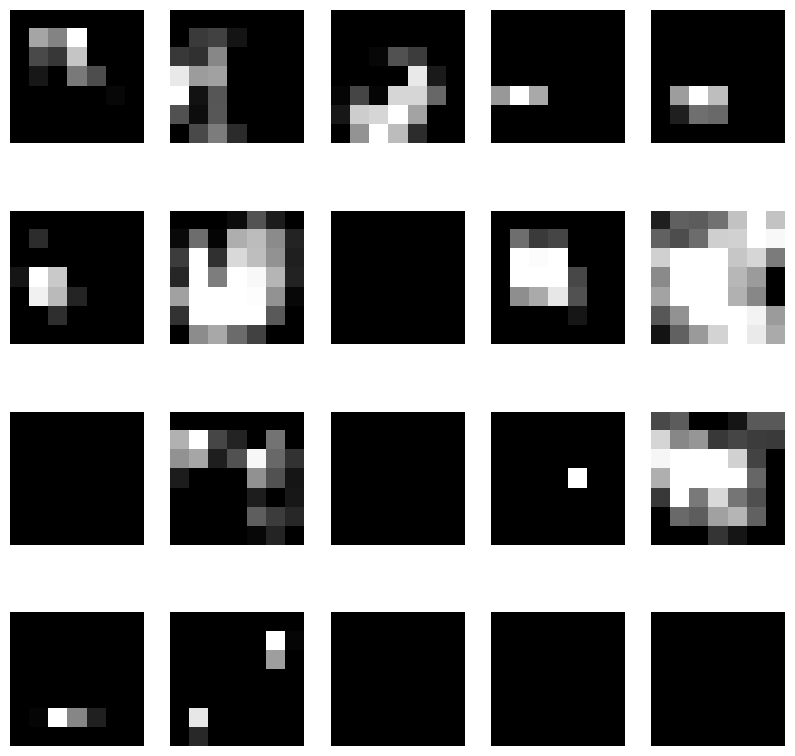

In [ ]:
layer_name = 'out_relu'
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
feature_maps = feature_extractor(tf.expand_dims(images[0], axis=0))

plt.figure(figsize=(10, 10))
for i in range(20):
  plt.subplot(4, 5, i + 1)
  plt.imshow(feature_maps[0, :, :, i], cmap='gray')
  plt.axis('off')

plt.show()

# **Pelatihan Model**

Deklarasi early stopping untuk mencegah overfitting selama pelatihan model

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Bersihkan sesi Keras untuk membebaskan sumber daya

In [ ]:
tf.keras.backend.clear_session()

Kompilasi, latih, serta validasi model dengan data train dan data validation

In [ ]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

trained_model = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[earlystopping])

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5933 - loss: 0.8987 - val_accuracy: 0.8272 - val_loss: 0.4004
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7787 - loss: 0.4750 - val_accuracy: 0.8210 - val_loss: 0.3537
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7930 - loss: 0.4363 - val_accuracy: 0.9074 - val_loss: 0.2906
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8379 - loss: 0.3770 - val_accuracy: 0.9198 - val_loss: 0.2356
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8532 - loss: 0.3467 - val_accuracy: 0.9136 - val_loss: 0.2562
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8787 - loss: 0.3001 - val_accuracy: 0.9198 - val_loss: 0.2260
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8855 - loss: 0.2867 - val_accuracy: 0.9074 - val_loss: 0.2209
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8962 - loss: 0.2565 - val_accuracy: 0.9

Tampilkan Grafik Akurasi dan Loss Hasil Pelatihan Model

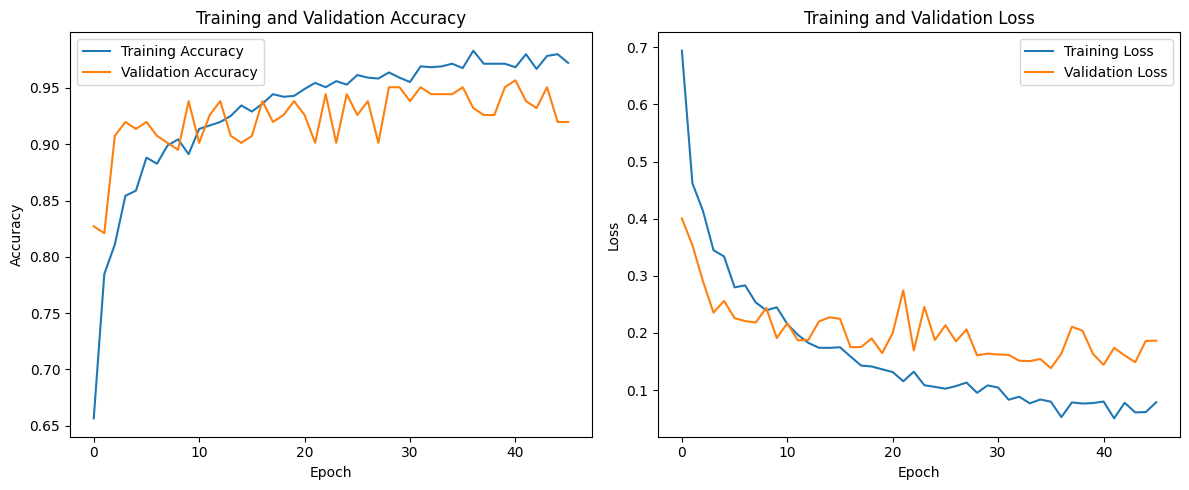

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(trained_model.history['accuracy'], label='Training Accuracy')
plt.plot(trained_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trained_model.history['loss'], label='Training Loss')
plt.plot(trained_model.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Simpan model

In [ ]:
model.save('model.keras')

# **Evaluasi Model**

Instal pustaka python-docx untuk kebutuhan penyimpanan hasil prediksi

In [ ]:
pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


Impor pustaka untuk kebutuhan evaluasi model dan penyimpanan hasil prediksi

In [ ]:
import seaborn as sns
from sklearn import metrics
import os
import csv
import pandas as pd
from docx import Document
from docx.shared import Inches

Muat model yang telah disimpan

In [ ]:
model = tf.keras.models.load_model('model.keras')

Ambil kelas aktual dari data test ke dalam list

In [ ]:
actual = []
for images, labels in test_ds:
  for label in labels:
    actual.append(label.numpy())

Buat prediksi terhadap data test

In [ ]:
predictions = model.predict(test_ds)
predicted = [1 if prediction > 0.5 else 0 for prediction in predictions]

accuracy = metrics.accuracy_score(actual, predicted)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Test Accuracy: 95.06%


Simpan hasil prediksi ke dalam file berformat csv

In [ ]:
# Get the total number of images in the test dataset
total_images = len(actual)

# Get a list of image file paths from the test dataset directory
image_paths = []
for filename in os.listdir('output/test/ergonomis'):
  image_paths.append(os.path.join('output/test/ergonomis', filename))
for filename in os.listdir('output/test/non-ergonomis'):
  image_paths.append(os.path.join('output/test/non-ergonomis', filename))

# Prepare a list to store actual labels, mapped from your `actual` variable
actual_labels = ['Ergonomis' if label == 0 else 'Tidak Ergonomis' for label in actual[:total_images]]

# Prepare a list to store predicted labels, mapped from your `predicted` variable
predicted_labels = ['Ergonomis' if label == 0 else 'Tidak Ergonomis' for label in predicted[:total_images]]

# Create and write to the CSV file
with open('predicted_images.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Citra', 'Kelas Aktual', 'Kelas Hasil Prediksi'])  # Write header row
    for i in range(total_images):
        writer.writerow([image_paths[i], actual_labels[i], predicted_labels[i]])

Muat file csv dan simpan isi file tersebut ke dalam docx

In [ ]:
# Read the CSV file
csv_file = 'predicted_images.csv'
data = pd.read_csv(csv_file)

# Create a new Document
doc = Document()

# Create a table with 1 header row and 3 columns
table = doc.add_table(rows=1, cols=3)
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Citra'
hdr_cells[1].text = 'Kelas Aktual'
hdr_cells[2].text = 'Kelas Hasil Prediksi'

# Loop through each row in the DataFrame
for index, row in data.iterrows():
    # Create a new row for each image
    row_cells = table.add_row().cells

    # Add the image to the first cell
    img_path = row['Citra']
    if os.path.exists(img_path):  # Check if the image file exists
        paragraph = row_cells[0].add_paragraph()
        run = paragraph.add_run()
        run.add_picture(img_path, width=Inches(2))  # Adjust width as necessary
    else:
        row_cells[0].text = f"Tidak ada citra: {img_path}"

    # Add actual and predicted labels to the other cells
    row_cells[1].text = str(row['Kelas Aktual'])
    row_cells[2].text = str(row['Kelas Hasil Prediksi'])

# Save the document
doc.save('predicted_images.docx')

# **Confusion Matrix dan Matriks Pengujian**

Deklarasi confusion matrix dan tampilkan nilai TP, TN, FP, dan FN

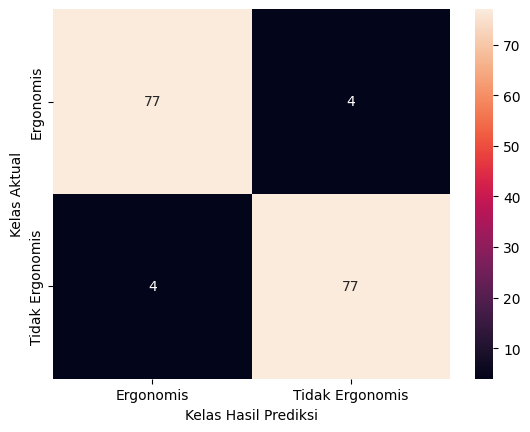

In [ ]:
cm = metrics.confusion_matrix(actual, predicted)

sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Ergonomis', 'Tidak Ergonomis'], yticklabels=['Ergonomis', 'Tidak Ergonomis'])
plt.ylabel('Kelas Aktual')
plt.xlabel('Kelas Hasil Prediksi')
plt.show()

Hitung nilai matriks pengujian

In [ ]:
TP = cm[0, 0]
FP = cm[0, 1]
TN = cm[1, 1]
FN = cm[1, 0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

Tampilkan hasil matriks pengujian

In [ ]:
print(f"Accuracy\t: {accuracy * 100:.2f}%")
print(f"Precision\t: {precision * 100:.2f}%")
print(f"Recall\t\t: {recall * 100:.2f}%")
print(f"F1 Score\t: {f1_score * 100:.2f}%")

Accuracy	: 95.06%
Precision	: 95.06%
Recall		: 95.06%
F1 Score	: 95.06%
